In [1]:
#mixup.py
import math
import random

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.datasets import mnist, cifar10
from keras.layers import Activation, Input, Dense, Conv2D, LeakyReLU, AveragePooling2D
from keras.layers import Dropout, BatchNormalization, Flatten, Reshape, SpatialDropout2D

Using TensorFlow backend.


In [2]:
def _mixup_batch(in_batch: np.ndarray, out_batch: np.ndarray, alpha: int = 1.0):
    """Mixup the batch by sampling from a beta distribution and 
    computing a weighted average of the first half of the batch with last half."""
    half = in_batch.shape[0] // 2
    mixed_ins = np.zeros((half,) + in_batch.shape[1:])
    mixed_outs = np.zeros((half,) + out_batch.shape[1:])
    for i in range(half):
        weight0 = np.random.beta(alpha, alpha)
        weight1 = 1 - weight0
        mixed_ins[i] = (in_batch[i, ...] * weight0) + (in_batch[half+i, ...] * weight1)
        mixed_outs[i] = (out_batch[i, ...] * weight0) + (out_batch[half+i, ...] * weight1)
    return mixed_ins, mixed_outs

In [3]:
def load_mnist():
    img_rows, img_cols = 28, 28

    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype('float32')
    x_train /= 128.0
    x_test /= 128.0
    x_train -= 1.0
    x_test -= 1.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    print('bounds:', np.min(x_train), np.max(x_train))
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)
    print('y_train sum:', np.sum(y_train, axis=0))
    return (x_train, y_train), (x_test, y_test)

In [4]:
def load_cifar():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255.0
    x_test /= 255.0
    #x_train -= 1.0
    #x_test -= 1.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    print('bounds:', np.min(x_train), np.max(x_train))
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')	
    return (x_train, y_train), (x_test, y_test)

In [5]:
def _plot_batch(image_batch):
    batch_size = image_batch.shape[0]
    sqrt_batch = math.ceil(math.sqrt(batch_size))
    _, axes = plt.subplots(sqrt_batch, sqrt_batch, figsize=(18, 14))
    for i in range(batch_size):
        if image_batch.shape[-1] == 1:
            axes[i//sqrt_batch, i%sqrt_batch].imshow(image_batch[i, :, :, 0])
        else:
            axes[i//sqrt_batch, i%sqrt_batch].imshow(image_batch[i, ...])

In [6]:
def build_discriminative_model(in_shape, out_classes):
    d_input = Input(in_shape)
    H = Conv2D(128, (3, 3), strides=(1,1), padding='same')(d_input)
    H = BatchNormalization()(H)
    H = LeakyReLU(0.2)(H)
    H = Conv2D(256, (3, 3), strides=(2,2), padding='same')(H)
    H = BatchNormalization()(H)
    H = LeakyReLU(0.2)(H)
    H = Conv2D(256, (3, 3), strides=(2,2), padding='same')(H)
    H = BatchNormalization()(H)
    H = LeakyReLU(0.2)(H)
    H = Flatten()(H)
    H = Dense(128)(H)
    H = BatchNormalization()(H)
    d_V = Dense(out_classes, activation='softmax')(H)
    discriminator = Model(d_input, d_V)
    discriminator.compile(loss='categorical_crossentropy', optimizer='adam')
    discriminator.summary()
    return discriminator

In [7]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
def _accuracy_on_batch(discriminator, batch, y):
    y_hat = discriminator.predict(batch)
    y_hat_idx = np.argmax(y_hat, axis=-1)
    y_idx = np.argmax(y, axis=-1)
    diff = y_idx-y_hat_idx
    n_tot = y.shape[0]
    n_rig = (diff==0).sum()
    acc = n_rig*100.0/n_tot
    print(f'Accuracy: {acc:0.02f} pct ({n_rig} of {n_tot}).')

In [9]:
def _get_batch(x, y, batch_size):
    indexes = np.random.randint(0, x.shape[0], size=batch_size)
    return x[indexes, ...], y[indexes, ...]

In [10]:
def _train_on_batches(discriminator, x_train, y_train, x_test, y_test, steps, batch_size, mixup=False, alpha=1.0, steps_per_print=100):
    losses = []
    test_losses = []
    if mixup:
        batch_size *= 2
    for s in range(steps):
        image_batch, class_label = _get_batch(x_train, y_train, batch_size)
        if mixup:
            image_batch, class_label = _mixup_batch(image_batch, class_label, alpha)
        d_loss = discriminator.train_on_batch(image_batch, class_label)
        if s%steps_per_print == 0:
            losses.append(d_loss)
            image_batch, class_label = _get_batch(x_test, y_test, batch_size)
            #_accuracy_on_batch(discriminator, image_batch, class_label)
            test_losses.append(discriminator.evaluate(image_batch, class_label))
    return losses, test_losses

11493376/11490434 [==============================] - 0s 0us/step
bounds: -1.0 0.9921875
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)
y_train sum: [5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]


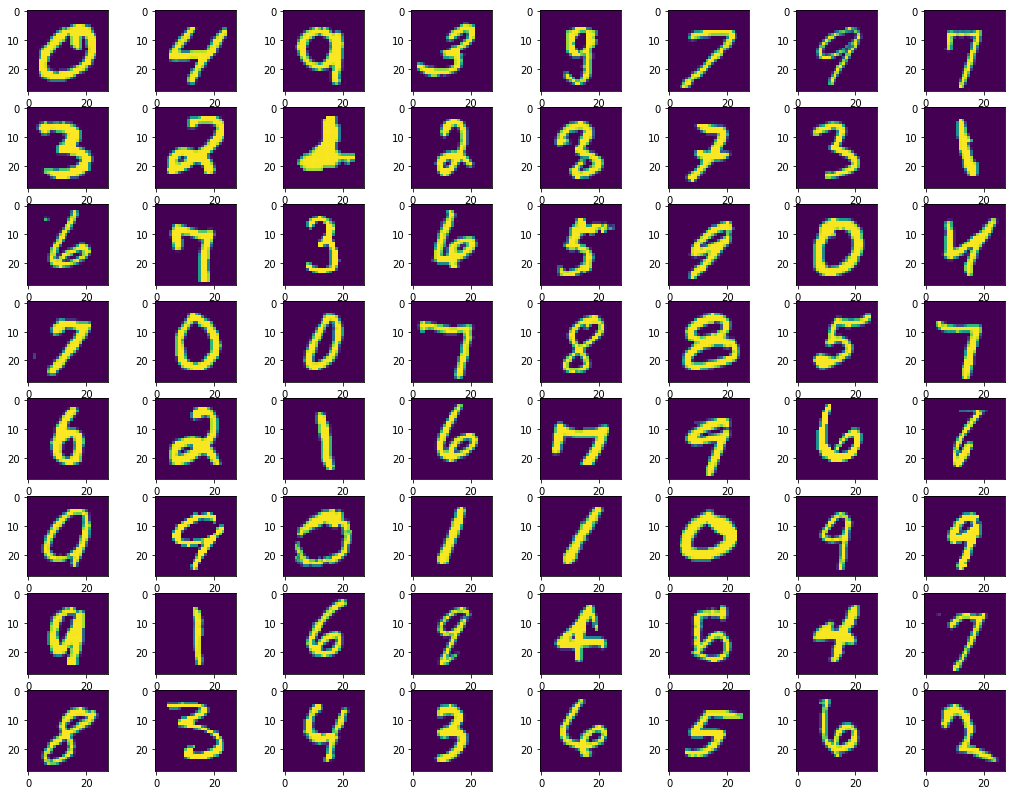

In [11]:
(mnist_x, mnist_y), (mnist_test_x, mnist_test_y) = load_mnist()
_plot_batch(_get_batch(mnist_x, mnist_y, 64)[0])

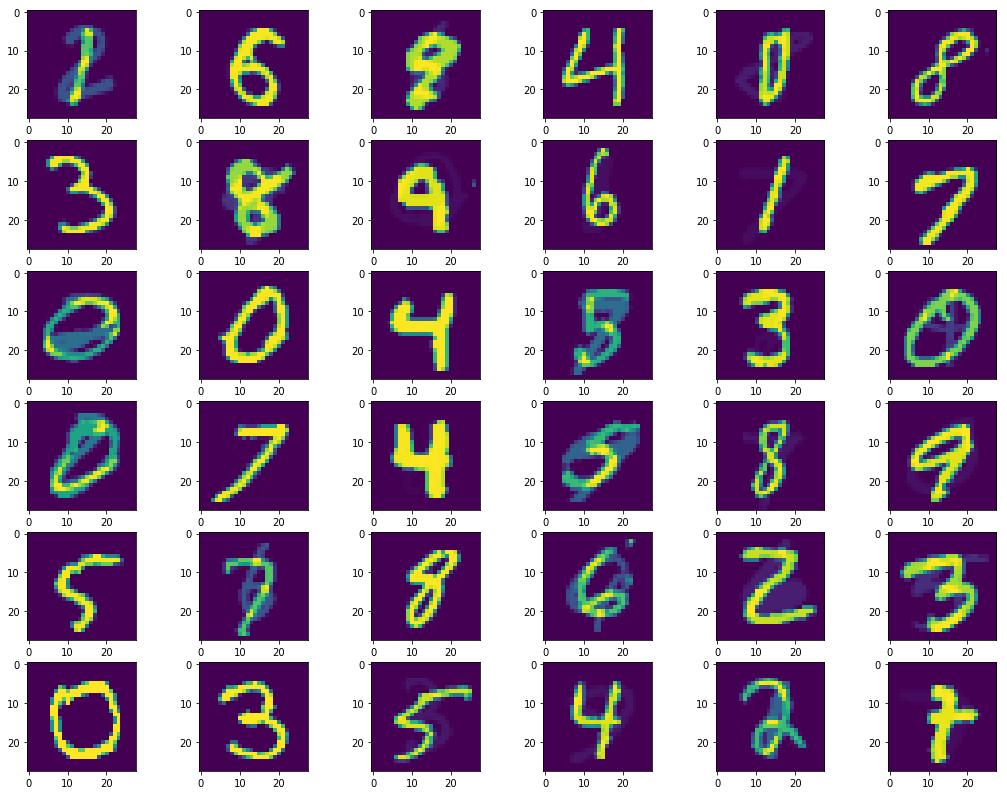

In [12]:
x, y = _get_batch(mnist_x, mnist_y, 72)
_plot_batch(_mixup_batch(x, y, alpha=0.3)[0])    

In [13]:
mnist_discriminator = build_discriminative_model((28, 28, 1), 10)
losses = {}
losses['erm'], losses['test_erm'] = _train_on_batches(mnist_discriminator, mnist_x, mnist_y, 
                                                      mnist_test_x, mnist_test_y, 
                                                      2000, 256, mixup=False, steps_per_print=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 256)       0         
__________

256/256 [==============================] - 0s 181us/step


In [14]:
mnist_discriminator = build_discriminative_model((28, 28, 1), 10)
losses['mixup_0.1'], losses['test_mixup_0.1'] = _train_on_batches(mnist_discriminator, mnist_x, mnist_y,
                                                                  mnist_test_x, mnist_test_y,
                                                                  2000, 256, mixup=True, alpha=0.1, steps_per_print=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 256)       0         
__________

512/512 [==============================] - 0s 188us/step


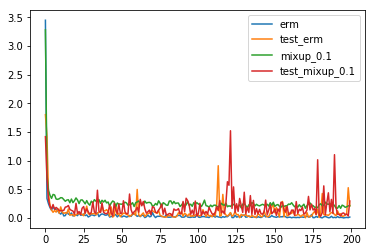

In [15]:
for k in losses:
    plt.plot(losses[k], label=k)
plt.legend(list(losses.keys()), loc='upper right')

170500096/170498071 [==============================] - 2s 0us/step
bounds: 0.0 1.0
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


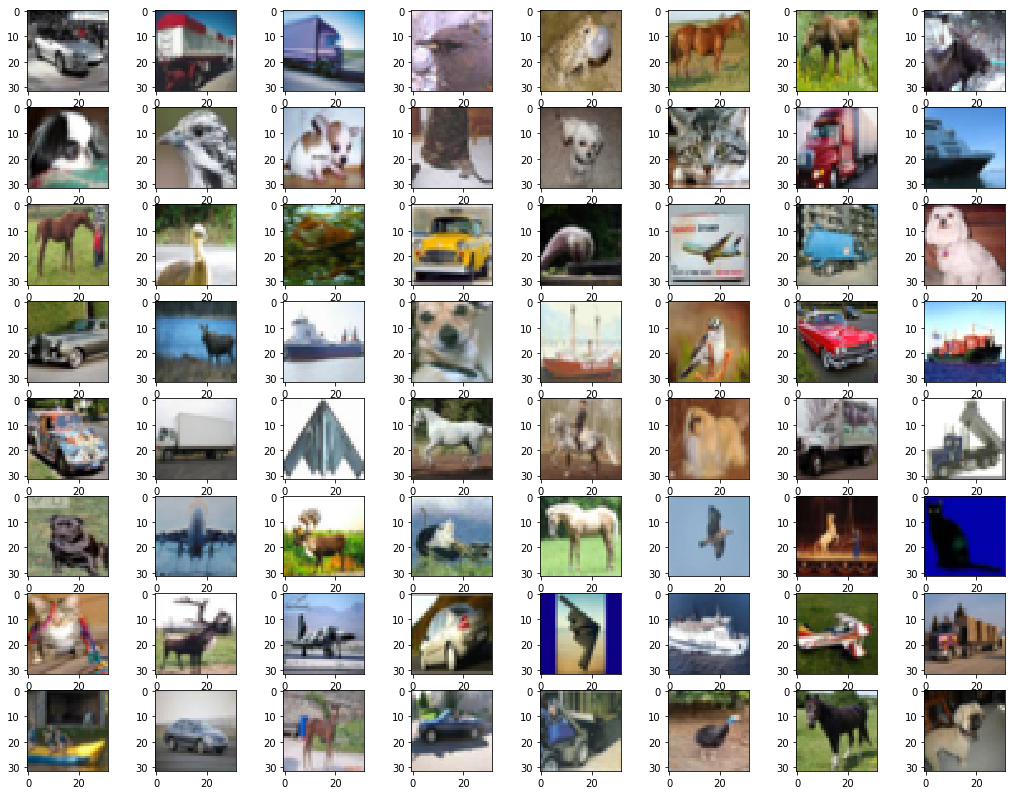

In [16]:
(cifar_x, cifar_y), (cifar_x_test, cifar_y_test) = load_cifar()
_plot_batch(_get_batch(cifar_x, cifar_y, 64)[0])

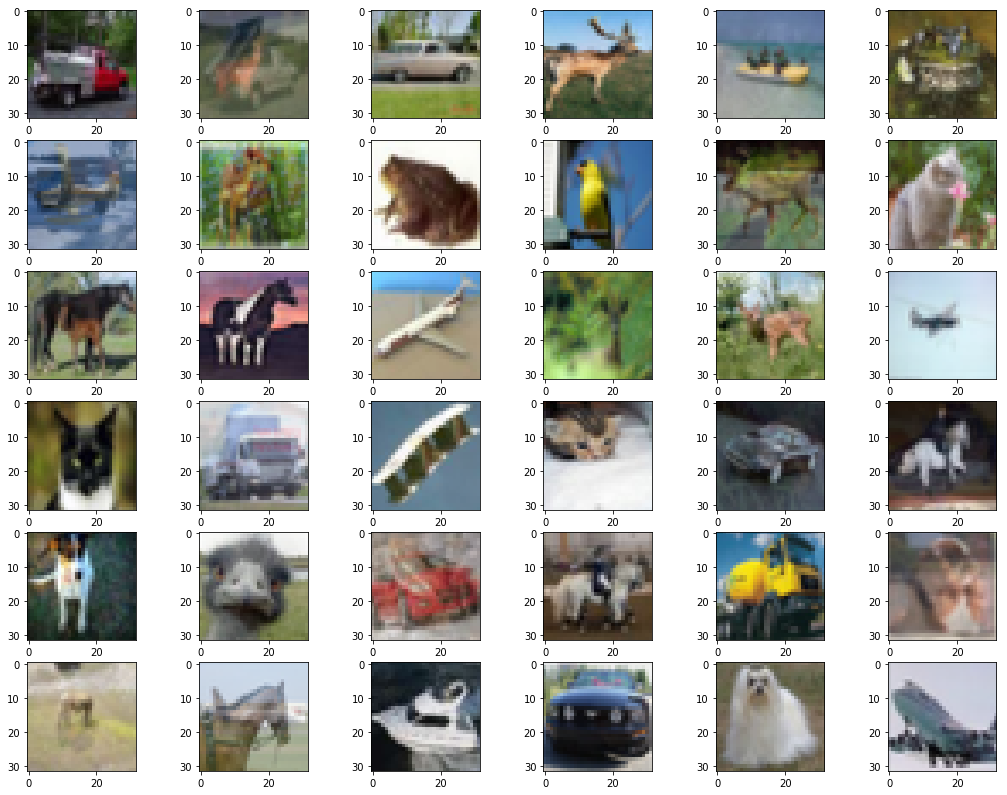

In [17]:
x, y = _get_batch(cifar_x, cifar_y, 72)
_plot_batch(_mixup_batch(x, y, alpha=0.3)[0])    

In [ ]:
cifar_discriminator = resnet_v2(input_shape=(32, 32, 3), depth=29)#build_discriminative_model((32, 32, 3), 10)
cifar_discriminator.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3))
cifar_discriminator.summary()

In [ ]:
losses = {}
losses['cifar_erm'], losses['test_cifar_erm'] = _train_on_batches(cifar_discriminator, cifar_x, cifar_y, 
                                                                  cifar_x_test, cifar_y_test,
                                                                  4000, 256, mixup=False, steps_per_print=5)

In [ ]:
cifar_discriminator = resnet_v2(input_shape=(32, 32, 3), depth=29)#build_discriminative_model((32, 32, 3), 10)
cifar_discriminator.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3))
losses['cifar_mixup_0.1'], losses['test_cifar_mixup_0.1'] = _train_on_batches(cifar_discriminator, cifar_x, cifar_y,
                                                                              cifar_x_test, cifar_y_test,
                                                                              4000, 256, mixup=True, alpha=0.1, steps_per_print=5)

In [ ]:
for k in losses:
    plt.plot(losses[k], label=k)
plt.legend(list(losses.keys()), loc='upper right')